# Implementación de aloritmos de selección de variales para clustering

In [7]:
import pandas as pd
import numpy as np
import glob, sys, os
import pytraj as pyt
sys.path.append(r'..')

In [46]:
prot_name = 'cdk2'
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_string = '../data/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json'.split('/')
path_to_json_file = glob.glob((os.path.join(*path_string)))[0]
                      
df_prot = pd.read_json(path_to_json_file)
df_prot.head()

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf,AUC_vrd_16x,AUC_vina_16x,AUC_ad4_LC,AUC_ad4_LE
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b,0.730317,0.575339,0.634163,0.572172
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.677828,0.546154,0.571946,0.483032
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.764706,0.580543,0.670814,0.607919
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298,96.308725,2,"[7, 4]","[[40, 46], [295, 298]]",0,[],,,inact_a,0.708145,0.535294,0.613348,0.544344
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",2,"['EDO', 'PVB']",PVB,214.0,inact_a,0.766968,0.571493,0.764932,0.715385


In [8]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = (os.path.join('..', '..', 'ARCHIVOS', 'CRISTALES', 'TRAJ_CRISTALS_PDB',
                        F'PDB_402_cdk2_PISANI_ALL.pdb'))
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 4848.


In [ ]:
# PCA

In [35]:
from copy import copy
from sklearn.decomposition import PCA
pca_obj = make_pipeline(StandardScaler(),
                    PCA(n_components= 2))

In [36]:
def get_new_dimentions(dmr_obj, traj, frames = None, atom_mask = "@CA", nca = False, y = None):
    ''' Retorna un objeto pca dada una trayectoria de pytraj y una mascara de selección'''
    if frames is None:
        frames = range(0, traj.n_frames)
    traj_subset = traj_crystals[frames, atom_mask]
    xyz_2d_array = traj_subset.xyz.reshape(traj_subset.n_frames, traj_subset.n_atoms * 3)
    # Crea una copia del estimador para evitar reentrenar el mismo objeto
    dmr_obj_copy = copy(dmr_obj)
    if nca:
        reduced = dmr_obj_copy.fit_transform( X = xyz_2d_array, y = y)
    else:
        reduced = dmr_obj_copy.fit_transform( xyz_2d_array )
    return reduced

In [38]:
from modules.plotting_functions import plot_points, plot_anotation_labels
import matplotlib.pyplot as plt

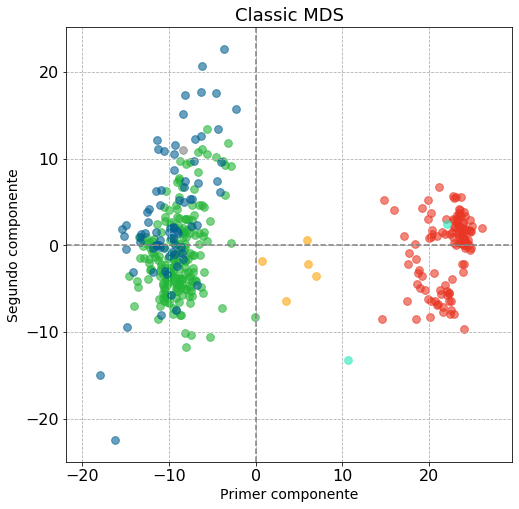

In [56]:
pyt.align(traj_crystals, "@CA")
# PCA
pca_pyt_all = get_new_dimentions(pca_obj, traj_crystals, atom_mask = pisani_mask)

plt.figure(figsize = (8,8))
plot_points(mds = pca_pyt_all.T, labels = df_prot.Labels_conf)

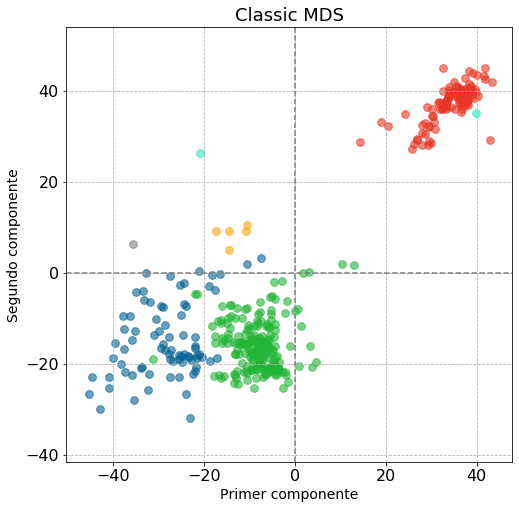

In [50]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
nca = make_pipeline(StandardScaler(),
                    NeighborhoodComponentsAnalysis(n_components = 2, init='identity'))

pca_pyt_all = get_new_dimentions(nca, traj_crystals, 
                                 atom_mask = "@CA", nca = True, y = df_prot.Labels_conf)
plt.figure(figsize = (8,8))
plot_points(mds = pca_pyt_all.T, labels = df_prot.Labels_conf)

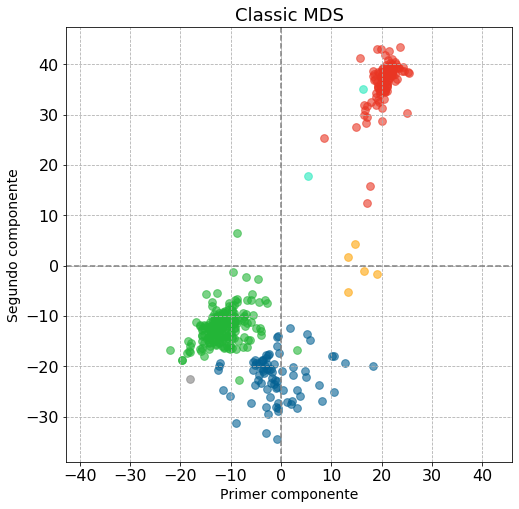

In [52]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",") # subsecuencia de la estructura secuendaria
pocket_residues = get_pocket_residues(sep=",")
# Máscara indicando los CA de los residuos de Pisani
pisani_mask = F"(:{pisiani_residues})&(@CA)"

pca_pyt_all = get_new_dimentions(nca, traj_crystals, 
                                 atom_mask = pisani_mask, nca = True, y = df_prot.Labels_conf)
plt.figure(figsize = (8,8))
plot_points(mds = pca_pyt_all.T, labels = df_prot.Labels_conf)

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


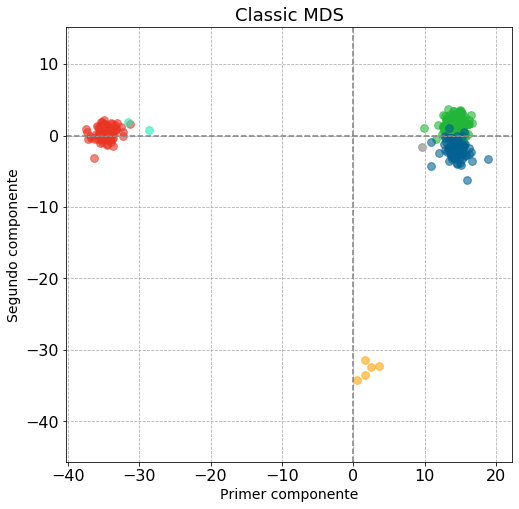

In [68]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = make_pipeline(StandardScaler(),
                   LinearDiscriminantAnalysis(n_components = 3))

pca_pyt_all = get_new_dimentions(lda, traj_crystals, 
                                 atom_mask = '', nca = True, y = df_prot.Labels_conf)
plt.figure(figsize = (8,8))
plot_points(mds = pca_pyt_all.T, labels = df_prot.Labels_conf)

In [72]:
c = lda['lineardiscriminantanalysis'].scalings_
c

array([[ 1.77564630e-03, -6.30473841e-05,  3.43595456e-03,
         1.15384943e-02,  3.34628391e-03],
       [-8.02652651e-04, -5.13199231e-03,  5.75401794e-03,
        -6.51626057e-03,  4.38118249e-03],
       [ 5.51212342e-03, -4.79398663e-03, -5.65279030e-03,
         1.67193222e-03, -7.48258746e-03],
       ...,
       [ 3.49049766e-03, -8.28771295e-04, -1.88895077e-03,
        -2.03687391e-03,  1.11281269e-02],
       [-4.26881984e-03,  6.68530676e-04, -6.74949279e-03,
        -4.81679678e-03,  2.74957453e-03],
       [ 3.00316723e-03,  3.40466158e-03, -1.48553702e-03,
        -3.50979199e-03, -6.49013167e-03]])